# import & get article ID

In [5]:
import requests, json, os, csv, re 
import numpy as np
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup as BS

with open ('nhk/nhk.json', 'r') as f:
    ids = sorted(x['id'] for x in json.load(f))
    print('oldest ID: %s' % ids[0])
    print('newest ID: %s' % ids[-1])
    print(len(ids))

oldest ID: 185875
newest ID: 201038
630


# Scrape

In [18]:
total_list = []
for i in range(200780, 203000):
    url = f"https://www3.nhk.or.jp/nhkworld/th/news/{i}/"
    response = requests.get(url)
    response.encoding='utf-8'
    if response.status_code == 200:
        dic = {}
        soup = BS(response.text, "html.parser")
        data = soup.find('script',type="application/ld+json")
        data = json.loads(data.text)
        dic['headline'] = data['headline']
        dic['article'] = data['articleBody']
        dic['date'] = data['datePublished']
        dic['url'] = url
        dic['id'] = str(i)
        total_list.append(dic)

with open ('nhk/nhk_new.json', 'w') as f:
    with open ('nhk/nhk.json', 'r') as g:
        old_list = json.load(g)
        for dic in total_list:
            if dic not in old_list:
                old_list.append(dic)
    json.dump(old_list, f, ensure_ascii=False, indent=4)

# Delete & Rename

In [4]:
if os.path.exists('nhk/nhk.json') and os.path.exists('nhk/nhk_new.json') and os.path.getsize('nhk/nhk_new.json') > os.path.getsize('nhk/nhk.json'):
    os.remove('nhk/nhk.json')
    os.rename('nhk/nhk_new.json', 'nhk/nhk.json')

# tokenize

In [3]:
from pythainlp import word_tokenize as wt
def clean(text):
    text = re.sub(r'https?://\S* ', '', text)
    text = re.sub(r'\r?(\n|\t)', ' ', text)
    text = re.sub(r'"+', '', text)
    return wt(text, keep_whitespace=False)

with open('nhk/nhk.json') as f:
    data = json.load(f)
with open('nhk/nhk_tokenized.txt','w') as f:
    tokenized = [clean(news_dic['article']) for news_dic in data]
    writer = csv.writer(f, lineterminator='\n', delimiter=' ')
    writer.writerows(tokenized)

# Word2Vec


In [15]:
from gensim.models import word2vec
model = word2vec.Word2Vec(tokenized, size=200, min_count=3, window=5, iter=100)

In [16]:
len(model.wv.vocab)

3143

# word frequency

In [5]:
import collections 
from pythainlp import corpus
count = collections.Counter()
stop = collections.Counter()
stops = corpus.thai_stopwords()
for line in tokenized:
    for word in line:
        count[word] += 1
        if word not in stops and word not in ['2', '-']:
            stop[word] += 1
print(stop.most_common(10))

[('ญี่ปุ่น', 1196), ('สหรัฐ', 608), ('ระบุ', 449), ('คน', 421), ('ตุลาคม', 401), ('จีน', 362), ('ปี', 362), ('กล่าวว่า', 351), ('เกาหลีใต้', 293), ('ที่จะ', 265)]


In [5]:
for i in count.most_common(30):
    print(i[0], end=' ')

ที่ ของ ใน และ ได้ ว่า การ ญี่ปุ่น มี จะ นาย เป็น นี้ วัน ให้ สหรัฐ เมื่อ กับ จาก โดย ซึ่ง ไม่ เพื่อ ระบุ คน ตุลาคม ขึ้น ยัง จีน ปี

In [6]:
for i in stop.most_common(30):
    print(i[0], end=' ')

ญี่ปุ่น สหรัฐ ระบุ คน ตุลาคม จีน ปี กล่าวว่า เกาหลีใต้ ที่จะ จังหวัด ประธานาธิบดี รัฐบาล เดือน เจ้าหน้าที่ พฤศจิกายน ชิ ต่าง ๆ เกาหลีเหนือ เรื่อง ประเทศ ผู้นำ เมือง ฮา รัฐมนตรี โตเกียว บริษัท ฮ่องกง เรียกร้อง กรุง

In [12]:
c = [i[1] for i in count.most_common()]
s = [i[1] for i in stop.most_common()]
print(len(c), len(s))

6497 6046


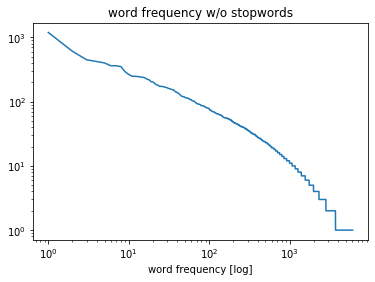

In [26]:
import matplotlib.pyplot as plt 
sx = range(1, len(s)+1)
plt.plot(sx, s)
plt.title('word frequency w/o stopwords')
plt.xlabel('word frequency [log]')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [23]:
LR = LinearRegression()
model = LR.fit([[np.log10(i)] for i in cx], np.log10(c))
print(model.coef_, model.intercept_, LR.score([[np.log10(i)] for i in cx], np.log10(c)))
logx = np.log10(cx)
y = 

[-1.32962702] 5.031931907433893 0.9581126828483045


In [27]:
LR = LinearRegression()
model = LR.fit([[np.log10(i)] for i in sx], np.log10(s))
print(model.coef_, model.intercept_, LR.score([[np.log10(i)] for i in sx], np.log10(s)))

[-1.20541247] 4.526787068415225 0.9445871188386182


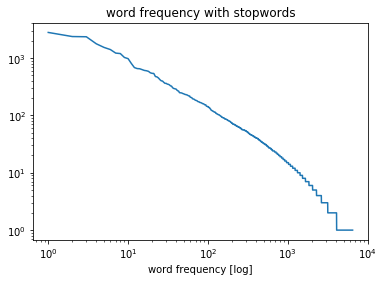

In [18]:
import matplotlib.pyplot as plt 
cx = range(1, len(c)+1)
plt.plot(cx, c)
plt.title('word frequency with stopwords')
plt.xlabel('word frequency [log]')
plt.xscale('log')
plt.yscale('log')
plt.show()